# Deploying a Machine Learning Model

In [1]:
from IPython.display import Image, display


Displaying image: apple.jpg


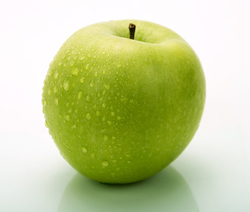


Displaying image: clock.jpg


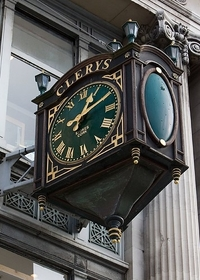


Displaying image: oranges.jpg


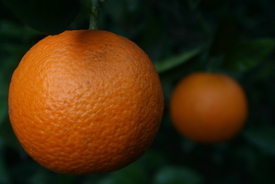


Displaying image: car.jpg


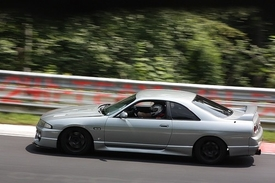

In [2]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

In [3]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

Image processed: apple.jpg

Detected object: apple with confidence level of 0.5717206597328186



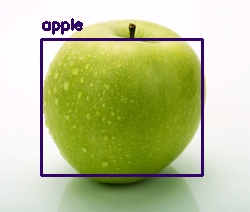

Image processed: clock.jpg

Detected object: clock with confidence level of 0.9683185815811157



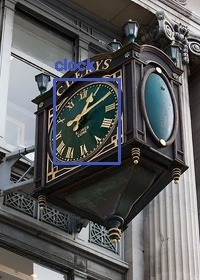

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185590028762817

Detected object: orange with confidence level of 0.5561688542366028



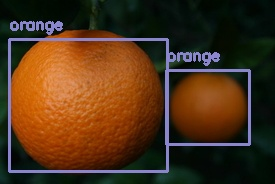

Image processed: car.jpg

Detected object: car with confidence level of 0.6325407028198242



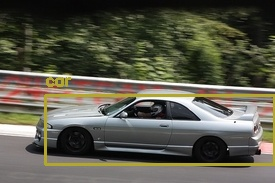

In [4]:
for image_file in image_files:
    detect_and_draw_box(image_file)

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346481204032898

Detected object: orange with confidence level of 0.515099287033081



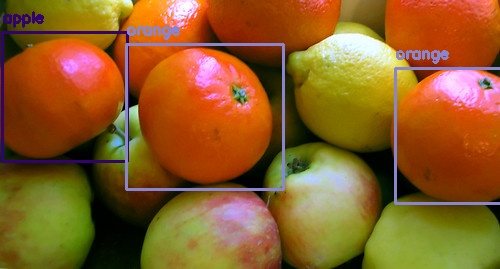

In [5]:
detect_and_draw_box("fruits.jpg")

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346481204032898

Detected object: orange with confidence level of 0.515099287033081

Detected object: apple with confidence level of 0.3475988507270813

Detected object: orange with confidence level of 0.3287608325481415

Detected object: apple with confidence level of 0.31244662404060364

Detected object: orange with confidence level of 0.2798607349395752

Detected object: orange with confidence level of 0.2749975323677063

Detected object: apple with confidence level of 0.2744506299495697

Detected object: orange with confidence level of 0.2141905575990677



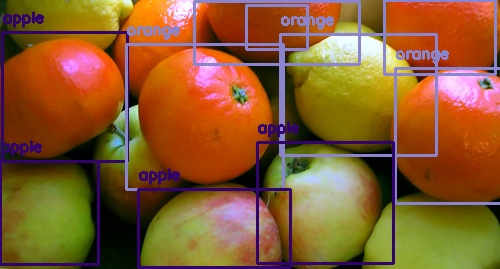

In [6]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

## Deploying the model using fastAPI

In [7]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [8]:
app = FastAPI(title='Deploying a ML Model with FastAPI')

class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


@app.get("/")
def home():
    return "Congratulations! Your API is working as expected."


@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    
    image_stream = io.BytesIO(file.file.read())
    
    image_stream.seek(0)
    
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    output_image = draw_bbox(image, bbox, label, conf)
    
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    return StreamingResponse(file_image, media_type="image/jpeg")

In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# This is an alias for localhost which means this particular machine
host = "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000, root_path="/serve")

INFO:     Started server process [64]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
